In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 7 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 180

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 3683.2329 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2022-12-31,128.570145,128.900558,128.936310,129.288147
AAPL,2023-01-01,128.204514,128.942719,128.858002,129.299866
AAPL,2023-01-02,128.363495,128.984879,128.851242,128.844162
AAPL,2023-01-03,128.499634,129.027039,128.624115,128.857468
AAPL,2023-01-04,128.445786,129.069199,128.726593,128.909119


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae          mse      mape       rmse    smape:
0  39.414008  1864.341159  0.226367  43.178017  26.04414

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  34.802073  1455.816376  0.199872  38.155162  22.596626

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  36.938844  1642.552098  0.212068  40.528411  24.176243

Model: CES
         mae          mse      mape      rmse     smape:
0  35.389771  1506.578603  0.203217  38.81467  23.028086

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape       rmse    smape:
0  54.423009  3962.734175  0.172518  62.950252  19.39089

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  60.606389  4904.662479  0.192127  70.033295  21.904838

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  57.572989  4434.431365  0.182476  66.591526  20.661464

Model: CES
         mae          mse      

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=180, n_windows=3, step_size=180, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2020-11-09,2020-11-06,114.001030,119.325462,117.402306,121.248627,116.389328,108.702827,124.075829,116.412987,115.049118,117.804604,116.357574,114.203644,118.578461
AAPL,2020-11-10,2020-11-06,113.658028,120.723885,117.391731,124.056038,116.452545,105.719864,127.185219,116.447609,114.483826,118.515686,116.848068,114.701050,119.112488
AAPL,2020-11-11,2020-11-06,117.107849,122.195244,116.851624,127.538872,116.515755,103.420509,129.611008,116.321991,114.019485,118.643135,116.494728,114.344528,118.755371
AAPL,2020-11-12,2020-11-06,116.833420,123.943596,116.453468,131.433731,116.578964,101.480354,131.677582,116.353157,113.481850,119.350731,116.936028,114.720383,119.146317
AAPL,2020-11-13,2020-11-06,116.882416,125.870705,115.923851,135.817566,116.642181,99.770943,133.513412,116.127350,113.011833,118.891075,116.999664,114.815002,119.237137


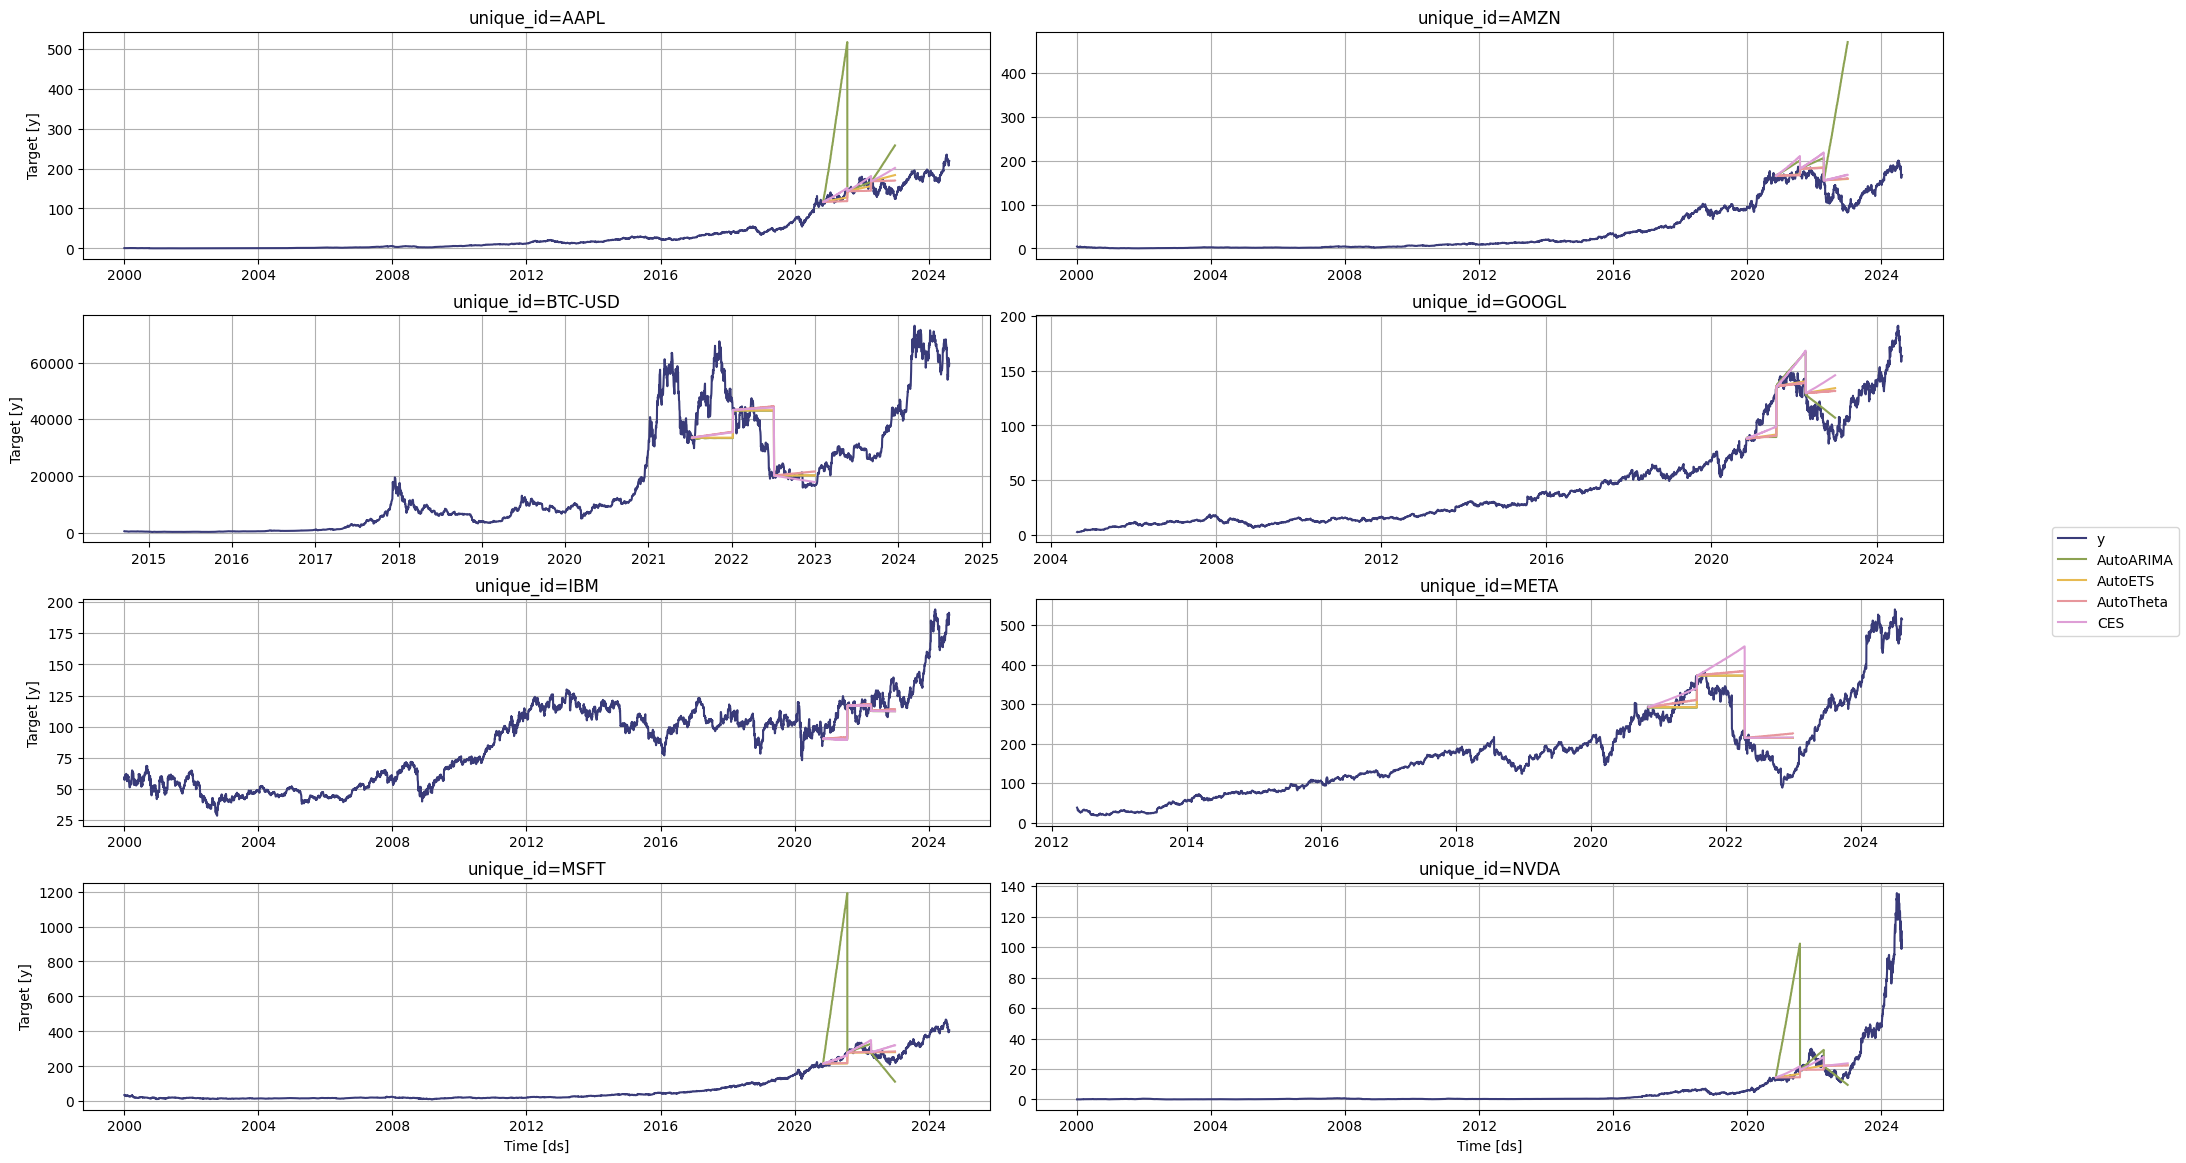

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))